<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase1/blob/master/EVA4_S6_With_L1_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

## Data Transformations



In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                       transforms.RandomRotation((-7,7),fill=(1,)),
                                      #  transforms.RandomHorizontalFlip(),
                                      #  transforms.RandomErasing(p=0.2), 
                                       transforms.ToTensor(),                                       
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 28x28x1 , out = 26x26x16, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 26x26x16 , out = 24x24x16, RF = 5
 
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # in = 24x24x16 , out = 12x12x16, RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 12x12x16 , out = 10x10x16, RF = 10
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 10x10x16 , out = 8x8x16, RF = 14

        # OUTPUT BLOCK
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 8x8x16 , out = 6x6x16, RF = 18
        self.Gap1 = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # in = 6x6x16 , out = 1x1x16, RF = 28	
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # in = 1x1x16 , out = 1x1x10, RF = 28

    def forward(self, x):
        x = self.convblock2(self.convblock1(x))
        x = self.pool1(x)
        x = self.convblock4(self.convblock3(x))
        x = self.Gap1(self.convblock5(x))
        x = self.fc1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           2,304
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [

# Training and Testing

In [0]:
from tqdm import tqdm

actual_img = []
wrong_pred = []
actual_target = []     

def train(model, device, train_loader, optimizer, epoch, factor):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  i = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    L1_Crit = nn.L1Loss(size_average=None, reduce=None, reduction='mean')
    reg_loss = 0 
    for param in model.parameters():
      zero_vector = torch.rand_like(param) * 0
      reg_loss += L1_Crit(param,zero_vector)
    loss += factor * reg_loss
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    # in view() method the shape of the desired output tensor is to be passed in as the parameter,
    # whereas in view_as() a tensor whose shape is to be mimicked it passed.
    # tensor.view_as(other) is equivalent to tensor.view(other.size())
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Train Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    if batch_idx == 468:
      train_acc_epoch.append(100*correct/processed)
      train_losses_epoch.append(loss)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    i = 0
    with torch.no_grad():

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            idx_incorrect = pred.ne(target.view_as(pred)).view(-1)
            actual_img.append(data[idx_incorrect.nonzero()].cpu().numpy())
            wrong_pred.append(pred[idx_incorrect.nonzero()].cpu().numpy())
            actual_target.append(target[idx_incorrect.nonzero()].cpu().numpy())
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Running the Model with L1

  0%|          | 0/469 [00:00<?, ?it/s]


<<<<<<<< With L1 >>>>>>>>
----------L1_Factor--------: 0.0005
EPOCH: 0


Loss=0.09804558753967285 Batch_id=468 Train Accuracy=91.48: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0547, Test Accuracy: 9850/10000 (98.50%)

EPOCH: 1


Loss=0.01608017459511757 Batch_id=468 Train Accuracy=98.07: 100%|██████████| 469/469 [00:25<00:00, 18.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Test Accuracy: 9861/10000 (98.61%)

EPOCH: 2


Loss=0.054119449108839035 Batch_id=468 Train Accuracy=98.43: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Test Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.059799447655677795 Batch_id=468 Train Accuracy=98.59: 100%|██████████| 469/469 [00:25<00:00, 18.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Test Accuracy: 9897/10000 (98.97%)

EPOCH: 4


Loss=0.016053922474384308 Batch_id=468 Train Accuracy=98.81: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Test Accuracy: 9917/10000 (99.17%)

EPOCH: 5


Loss=0.052331164479255676 Batch_id=468 Train Accuracy=98.86: 100%|██████████| 469/469 [00:26<00:00, 23.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Test Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.05693221464753151 Batch_id=468 Train Accuracy=98.93: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Test Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.022383293136954308 Batch_id=468 Train Accuracy=98.95: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.08370142430067062 Batch_id=468 Train Accuracy=99.06: 100%|██████████| 469/469 [00:25<00:00, 18.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Test Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.06216900050640106 Batch_id=468 Train Accuracy=99.07: 100%|██████████| 469/469 [00:26<00:00, 17.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Test Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=0.03154062107205391 Batch_id=468 Train Accuracy=99.09: 100%|██████████| 469/469 [00:26<00:00, 17.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.026711132377386093 Batch_id=468 Train Accuracy=99.15: 100%|██████████| 469/469 [00:27<00:00, 17.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 12


Loss=0.010918663814663887 Batch_id=468 Train Accuracy=99.15: 100%|██████████| 469/469 [00:26<00:00, 17.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.01446105819195509 Batch_id=468 Train Accuracy=99.20: 100%|██████████| 469/469 [00:25<00:00, 18.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.006955350749194622 Batch_id=468 Train Accuracy=99.19: 100%|██████████| 469/469 [00:25<00:00, 18.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Test Accuracy: 9922/10000 (99.22%)

EPOCH: 15


Loss=0.008261043578386307 Batch_id=468 Train Accuracy=99.30: 100%|██████████| 469/469 [00:26<00:00, 17.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.013995042070746422 Batch_id=468 Train Accuracy=99.21: 100%|██████████| 469/469 [00:26<00:00, 17.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 17


Loss=0.010761129669845104 Batch_id=468 Train Accuracy=99.29: 100%|██████████| 469/469 [00:26<00:00, 17.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.007070326246321201 Batch_id=468 Train Accuracy=99.26: 100%|██████████| 469/469 [00:25<00:00, 22.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.06889801472425461 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:26<00:00, 17.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Test Accuracy: 9946/10000 (99.46%)

EPOCH: 20


Loss=0.020259611308574677 Batch_id=468 Train Accuracy=99.36: 100%|██████████| 469/469 [00:26<00:00, 17.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 21


Loss=0.022088870406150818 Batch_id=468 Train Accuracy=99.30: 100%|██████████| 469/469 [00:26<00:00, 20.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 22


Loss=0.019678540527820587 Batch_id=468 Train Accuracy=99.33: 100%|██████████| 469/469 [00:26<00:00, 17.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 23


Loss=0.039007436484098434 Batch_id=468 Train Accuracy=99.33: 100%|██████████| 469/469 [00:26<00:00, 17.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 24


Loss=0.04368429630994797 Batch_id=468 Train Accuracy=99.35: 100%|██████████| 469/469 [00:26<00:00, 17.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 25


Loss=0.006150350905954838 Batch_id=468 Train Accuracy=99.41: 100%|██████████| 469/469 [00:26<00:00, 17.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 26


Loss=0.005211294628679752 Batch_id=468 Train Accuracy=99.39: 100%|██████████| 469/469 [00:27<00:00, 17.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 27


Loss=0.01629515364766121 Batch_id=468 Train Accuracy=99.45: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 28


Loss=0.05040714144706726 Batch_id=468 Train Accuracy=99.37: 100%|██████████| 469/469 [00:25<00:00, 18.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 29


Loss=0.012619107961654663 Batch_id=468 Train Accuracy=99.42: 100%|██████████| 469/469 [00:25<00:00, 18.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Test Accuracy: 9941/10000 (99.41%)

EPOCH: 30


Loss=0.0859348326921463 Batch_id=468 Train Accuracy=99.38: 100%|██████████| 469/469 [00:26<00:00, 20.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 31


Loss=0.014819543808698654 Batch_id=468 Train Accuracy=99.45: 100%|██████████| 469/469 [00:26<00:00, 17.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 32


Loss=0.023188136518001556 Batch_id=468 Train Accuracy=99.39: 100%|██████████| 469/469 [00:25<00:00, 18.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 33


Loss=0.007370803505182266 Batch_id=468 Train Accuracy=99.42: 100%|██████████| 469/469 [00:24<00:00, 18.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 34


Loss=0.030262667685747147 Batch_id=468 Train Accuracy=99.45: 100%|██████████| 469/469 [00:24<00:00, 19.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 35


Loss=0.042091287672519684 Batch_id=468 Train Accuracy=99.49: 100%|██████████| 469/469 [00:24<00:00, 19.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 36


Loss=0.015569954179227352 Batch_id=468 Train Accuracy=99.43: 100%|██████████| 469/469 [00:24<00:00, 22.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 37


Loss=0.021311024203896523 Batch_id=468 Train Accuracy=99.46: 100%|██████████| 469/469 [00:24<00:00, 19.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 38


Loss=0.00879783183336258 Batch_id=468 Train Accuracy=99.45: 100%|██████████| 469/469 [00:24<00:00, 18.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 39


Loss=0.06134101003408432 Batch_id=468 Train Accuracy=99.48: 100%|██████████| 469/469 [00:25<00:00, 18.71it/s]



Test set: Average loss: 0.0200, Test Accuracy: 9937/10000 (99.37%)


Maxium test accuracy: 99.46, Achieved in epoch: 19, Max Train accuracy : 99.49, Achieved in epoch : 35

----------L1_Factor--------: 0.005


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.11707659065723419 Batch_id=468 Train Accuracy=91.88: 100%|██████████| 469/469 [00:24<00:00, 19.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0564, Test Accuracy: 9854/10000 (98.54%)

EPOCH: 1


Loss=0.1618642807006836 Batch_id=468 Train Accuracy=98.15: 100%|██████████| 469/469 [00:24<00:00, 19.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Test Accuracy: 9885/10000 (98.85%)

EPOCH: 2


Loss=0.12403929233551025 Batch_id=468 Train Accuracy=98.47: 100%|██████████| 469/469 [00:24<00:00, 22.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Test Accuracy: 9912/10000 (99.12%)

EPOCH: 3


Loss=0.098276287317276 Batch_id=468 Train Accuracy=98.69: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Test Accuracy: 9918/10000 (99.18%)

EPOCH: 4


Loss=0.040924422442913055 Batch_id=468 Train Accuracy=98.74: 100%|██████████| 469/469 [00:24<00:00, 19.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Test Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.09797592461109161 Batch_id=468 Train Accuracy=98.84: 100%|██████████| 469/469 [00:24<00:00, 19.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Test Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.05737273395061493 Batch_id=468 Train Accuracy=98.91: 100%|██████████| 469/469 [00:24<00:00, 19.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Test Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.041018515825271606 Batch_id=468 Train Accuracy=98.98: 100%|██████████| 469/469 [00:24<00:00, 19.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Loss=0.07299696654081345 Batch_id=468 Train Accuracy=99.03: 100%|██████████| 469/469 [00:24<00:00, 19.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Test Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.12897492945194244 Batch_id=468 Train Accuracy=99.02: 100%|██████████| 469/469 [00:24<00:00, 18.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.03626773878931999 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:24<00:00, 18.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 11


Loss=0.03288286551833153 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:23<00:00, 19.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.041078586131334305 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:24<00:00, 19.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.08235981315374374 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:24<00:00, 19.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 14


Loss=0.03848279267549515 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:23<00:00, 24.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 15


Loss=0.10810022801160812 Batch_id=468 Train Accuracy=99.16: 100%|██████████| 469/469 [00:24<00:00, 19.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=0.04464229941368103 Batch_id=468 Train Accuracy=99.15: 100%|██████████| 469/469 [00:24<00:00, 19.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 17


Loss=0.03283022716641426 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Test Accuracy: 9918/10000 (99.18%)

EPOCH: 18


Loss=0.04167429357767105 Batch_id=468 Train Accuracy=99.26: 100%|██████████| 469/469 [00:26<00:00, 17.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 19


Loss=0.034715842455625534 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 20


Loss=0.05426054447889328 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:24<00:00, 19.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Test Accuracy: 9919/10000 (99.19%)

EPOCH: 21


Loss=0.06414058804512024 Batch_id=468 Train Accuracy=99.30: 100%|██████████| 469/469 [00:25<00:00, 18.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Test Accuracy: 9922/10000 (99.22%)

EPOCH: 22


Loss=0.09573408216238022 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:24<00:00, 19.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 23


Loss=0.029606305062770844 Batch_id=468 Train Accuracy=99.19: 100%|██████████| 469/469 [00:25<00:00, 18.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 24


Loss=0.058791302144527435 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:24<00:00, 18.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 25


Loss=0.05197732895612717 Batch_id=468 Train Accuracy=99.30: 100%|██████████| 469/469 [00:24<00:00, 19.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 26


Loss=0.024588568136096 Batch_id=468 Train Accuracy=99.22: 100%|██████████| 469/469 [00:23<00:00, 20.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 27


Loss=0.026374515146017075 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:23<00:00, 20.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 28


Loss=0.04336649179458618 Batch_id=468 Train Accuracy=99.28: 100%|██████████| 469/469 [00:24<00:00, 19.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Test Accuracy: 9922/10000 (99.22%)

EPOCH: 29


Loss=0.02715931087732315 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:23<00:00, 19.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 30


Loss=0.038772664964199066 Batch_id=468 Train Accuracy=99.32: 100%|██████████| 469/469 [00:23<00:00, 19.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Test Accuracy: 9943/10000 (99.43%)

EPOCH: 31


Loss=0.026826560497283936 Batch_id=468 Train Accuracy=99.27: 100%|██████████| 469/469 [00:23<00:00, 19.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Test Accuracy: 9926/10000 (99.26%)

EPOCH: 32


Loss=0.0748036801815033 Batch_id=468 Train Accuracy=99.28: 100%|██████████| 469/469 [00:23<00:00, 19.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 33


Loss=0.04923497885465622 Batch_id=468 Train Accuracy=99.27: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 34


Loss=0.02388814091682434 Batch_id=468 Train Accuracy=99.32: 100%|██████████| 469/469 [00:24<00:00, 19.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 35


Loss=0.0638531893491745 Batch_id=468 Train Accuracy=99.30: 100%|██████████| 469/469 [00:23<00:00, 24.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Test Accuracy: 9921/10000 (99.21%)

EPOCH: 36


Loss=0.02663169987499714 Batch_id=468 Train Accuracy=99.36: 100%|██████████| 469/469 [00:25<00:00, 18.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 37


Loss=0.026857994496822357 Batch_id=468 Train Accuracy=99.35: 100%|██████████| 469/469 [00:27<00:00, 17.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 38


Loss=0.03393619507551193 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:26<00:00, 17.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 39


Loss=0.031378328800201416 Batch_id=468 Train Accuracy=99.33: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]



Test set: Average loss: 0.0221, Test Accuracy: 9924/10000 (99.24%)


Maxium test accuracy: 99.43, Achieved in epoch: 30, Max Train accuracy : 99.36, Achieved in epoch : 36

----------L1_Factor--------: 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.07599681615829468 Batch_id=468 Train Accuracy=91.66: 100%|██████████| 469/469 [00:25<00:00, 21.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0622, Test Accuracy: 9822/10000 (98.22%)

EPOCH: 1


Loss=0.03555767610669136 Batch_id=468 Train Accuracy=98.04: 100%|██████████| 469/469 [00:25<00:00, 18.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Test Accuracy: 9889/10000 (98.89%)

EPOCH: 2


Loss=0.10791291296482086 Batch_id=468 Train Accuracy=98.45: 100%|██████████| 469/469 [00:24<00:00, 19.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Test Accuracy: 9901/10000 (99.01%)

EPOCH: 3


Loss=0.018015911802649498 Batch_id=468 Train Accuracy=98.64: 100%|██████████| 469/469 [00:24<00:00, 19.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Test Accuracy: 9910/10000 (99.10%)

EPOCH: 4


Loss=0.01706293597817421 Batch_id=468 Train Accuracy=98.79: 100%|██████████| 469/469 [00:24<00:00, 18.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 5


Loss=0.01470568310469389 Batch_id=468 Train Accuracy=98.87: 100%|██████████| 469/469 [00:24<00:00, 21.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Test Accuracy: 9898/10000 (98.98%)

EPOCH: 6


Loss=0.0109073081985116 Batch_id=468 Train Accuracy=98.85: 100%|██████████| 469/469 [00:24<00:00, 19.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Test Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.044082459062337875 Batch_id=468 Train Accuracy=98.94: 100%|██████████| 469/469 [00:24<00:00, 19.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Test Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Loss=0.06763119250535965 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:24<00:00, 19.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.05272739380598068 Batch_id=468 Train Accuracy=99.04: 100%|██████████| 469/469 [00:25<00:00, 18.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.0834985077381134 Batch_id=468 Train Accuracy=99.05: 100%|██████████| 469/469 [00:26<00:00, 17.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 11


Loss=0.007873307913541794 Batch_id=468 Train Accuracy=99.04: 100%|██████████| 469/469 [00:24<00:00, 18.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.05120690539479256 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:25<00:00, 18.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.06498046964406967 Batch_id=468 Train Accuracy=99.16: 100%|██████████| 469/469 [00:24<00:00, 19.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.028701771050691605 Batch_id=468 Train Accuracy=99.19: 100%|██████████| 469/469 [00:24<00:00, 19.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.011328929103910923 Batch_id=468 Train Accuracy=99.21: 100%|██████████| 469/469 [00:24<00:00, 19.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 16


Loss=0.009240375831723213 Batch_id=468 Train Accuracy=99.22: 100%|██████████| 469/469 [00:24<00:00, 19.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Test Accuracy: 9912/10000 (99.12%)

EPOCH: 17


Loss=0.04950767382979393 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:26<00:00, 17.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.004941300489008427 Batch_id=468 Train Accuracy=99.28: 100%|██████████| 469/469 [00:26<00:00, 17.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Test Accuracy: 9943/10000 (99.43%)

EPOCH: 19


Loss=0.01735537312924862 Batch_id=468 Train Accuracy=99.34: 100%|██████████| 469/469 [00:24<00:00, 18.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 20


Loss=0.039770953357219696 Batch_id=468 Train Accuracy=99.30: 100%|██████████| 469/469 [00:25<00:00, 18.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 21


Loss=0.009851309470832348 Batch_id=468 Train Accuracy=99.29: 100%|██████████| 469/469 [00:24<00:00, 19.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 22


Loss=0.003153511555865407 Batch_id=468 Train Accuracy=99.32: 100%|██████████| 469/469 [00:24<00:00, 19.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 23


Loss=0.005357014015316963 Batch_id=468 Train Accuracy=99.29: 100%|██████████| 469/469 [00:24<00:00, 19.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Test Accuracy: 9943/10000 (99.43%)

EPOCH: 24


Loss=0.016833215951919556 Batch_id=468 Train Accuracy=99.33: 100%|██████████| 469/469 [00:24<00:00, 18.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 25


Loss=0.007903747260570526 Batch_id=468 Train Accuracy=99.34: 100%|██████████| 469/469 [00:24<00:00, 19.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 26


Loss=0.020962735638022423 Batch_id=468 Train Accuracy=99.36: 100%|██████████| 469/469 [00:23<00:00, 19.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 27


Loss=0.055797696113586426 Batch_id=468 Train Accuracy=99.40: 100%|██████████| 469/469 [00:24<00:00, 19.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 28


Loss=0.002711850218474865 Batch_id=468 Train Accuracy=99.39: 100%|██████████| 469/469 [00:24<00:00, 19.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 29


Loss=0.038126520812511444 Batch_id=468 Train Accuracy=99.35: 100%|██████████| 469/469 [00:24<00:00, 19.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 30


Loss=0.008121042512357235 Batch_id=468 Train Accuracy=99.39: 100%|██████████| 469/469 [00:24<00:00, 19.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Test Accuracy: 9941/10000 (99.41%)

EPOCH: 31


Loss=0.0060315509326756 Batch_id=468 Train Accuracy=99.42: 100%|██████████| 469/469 [00:25<00:00, 23.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Test Accuracy: 9946/10000 (99.46%)

EPOCH: 32


Loss=0.01333084236830473 Batch_id=468 Train Accuracy=99.42: 100%|██████████| 469/469 [00:24<00:00, 19.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 33


Loss=0.0024331898894160986 Batch_id=468 Train Accuracy=99.41: 100%|██████████| 469/469 [00:24<00:00, 24.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 34


Loss=0.0038149296306073666 Batch_id=468 Train Accuracy=99.42: 100%|██████████| 469/469 [00:23<00:00, 19.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 35


Loss=0.06872207671403885 Batch_id=468 Train Accuracy=99.42: 100%|██████████| 469/469 [00:24<00:00, 19.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 36


Loss=0.06808917969465256 Batch_id=468 Train Accuracy=99.43: 100%|██████████| 469/469 [00:24<00:00, 19.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 37


Loss=0.015345283783972263 Batch_id=468 Train Accuracy=99.45: 100%|██████████| 469/469 [00:25<00:00, 18.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 38


Loss=0.015605777502059937 Batch_id=468 Train Accuracy=99.47: 100%|██████████| 469/469 [00:25<00:00, 18.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 39


Loss=0.013784817419946194 Batch_id=468 Train Accuracy=99.44: 100%|██████████| 469/469 [00:24<00:00, 19.16it/s]



Test set: Average loss: 0.0175, Test Accuracy: 9944/10000 (99.44%)


Maxium test accuracy: 99.46, Achieved in epoch: 31, Max Train accuracy : 99.47, Achieved in epoch : 38

----------L1_Factor--------: 0.001


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.0551164448261261 Batch_id=468 Train Accuracy=91.50: 100%|██████████| 469/469 [00:24<00:00, 18.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0664, Test Accuracy: 9805/10000 (98.05%)

EPOCH: 1


Loss=0.11556905508041382 Batch_id=468 Train Accuracy=98.00: 100%|██████████| 469/469 [00:25<00:00, 18.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Test Accuracy: 9881/10000 (98.81%)

EPOCH: 2


Loss=0.04724998399615288 Batch_id=468 Train Accuracy=98.49: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Test Accuracy: 9896/10000 (98.96%)

EPOCH: 3


Loss=0.024837501347064972 Batch_id=468 Train Accuracy=98.62: 100%|██████████| 469/469 [00:24<00:00, 19.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Test Accuracy: 9879/10000 (98.79%)

EPOCH: 4


Loss=0.0815538763999939 Batch_id=468 Train Accuracy=98.74: 100%|██████████| 469/469 [00:24<00:00, 19.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Test Accuracy: 9917/10000 (99.17%)

EPOCH: 5


Loss=0.06548625230789185 Batch_id=468 Train Accuracy=98.80: 100%|██████████| 469/469 [00:25<00:00, 18.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Test Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.031056847423315048 Batch_id=468 Train Accuracy=98.83: 100%|██████████| 469/469 [00:25<00:00, 18.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Test Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.04695398360490799 Batch_id=468 Train Accuracy=98.99: 100%|██████████| 469/469 [00:25<00:00, 18.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Test Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.020761530846357346 Batch_id=468 Train Accuracy=99.05: 100%|██████████| 469/469 [00:25<00:00, 18.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Test Accuracy: 9904/10000 (99.04%)

EPOCH: 9


Loss=0.03214656934142113 Batch_id=468 Train Accuracy=99.03: 100%|██████████| 469/469 [00:25<00:00, 22.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Test Accuracy: 9909/10000 (99.09%)

EPOCH: 10


Loss=0.023436151444911957 Batch_id=468 Train Accuracy=99.09: 100%|██████████| 469/469 [00:24<00:00, 19.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.029082268476486206 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:24<00:00, 19.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.020670603960752487 Batch_id=468 Train Accuracy=99.16: 100%|██████████| 469/469 [00:24<00:00, 19.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.028503695502877235 Batch_id=468 Train Accuracy=99.20: 100%|██████████| 469/469 [00:24<00:00, 19.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.014034842140972614 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:25<00:00, 18.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.011175952851772308 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:24<00:00, 19.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.02615286037325859 Batch_id=468 Train Accuracy=99.21: 100%|██████████| 469/469 [00:24<00:00, 18.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 17


Loss=0.014625145122408867 Batch_id=468 Train Accuracy=99.26: 100%|██████████| 469/469 [00:24<00:00, 19.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 18


Loss=0.023767154663801193 Batch_id=468 Train Accuracy=99.33: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.01514844037592411 Batch_id=468 Train Accuracy=99.24: 100%|██████████| 469/469 [00:24<00:00, 19.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 20


Loss=0.05323924496769905 Batch_id=468 Train Accuracy=99.26: 100%|██████████| 469/469 [00:24<00:00, 19.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 21


Loss=0.02946379780769348 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:25<00:00, 18.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 22


Loss=0.02754579856991768 Batch_id=468 Train Accuracy=99.32: 100%|██████████| 469/469 [00:24<00:00, 19.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 23


Loss=0.011581659317016602 Batch_id=468 Train Accuracy=99.33: 100%|██████████| 469/469 [00:24<00:00, 23.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 24


Loss=0.02522018551826477 Batch_id=468 Train Accuracy=99.39: 100%|██████████| 469/469 [00:24<00:00, 19.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 25


Loss=0.011458739638328552 Batch_id=468 Train Accuracy=99.32: 100%|██████████| 469/469 [00:24<00:00, 19.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 26


Loss=0.011422453448176384 Batch_id=468 Train Accuracy=99.38: 100%|██████████| 469/469 [00:24<00:00, 19.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Test Accuracy: 9944/10000 (99.44%)

EPOCH: 27


Loss=0.02304741181433201 Batch_id=468 Train Accuracy=99.38: 100%|██████████| 469/469 [00:24<00:00, 19.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 28


Loss=0.02658509649336338 Batch_id=468 Train Accuracy=99.37: 100%|██████████| 469/469 [00:23<00:00, 19.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 29


Loss=0.010885084047913551 Batch_id=468 Train Accuracy=99.44: 100%|██████████| 469/469 [00:23<00:00, 19.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Test Accuracy: 9944/10000 (99.44%)

EPOCH: 30


Loss=0.024421092122793198 Batch_id=468 Train Accuracy=99.47: 100%|██████████| 469/469 [00:24<00:00, 19.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 31


Loss=0.028162671253085136 Batch_id=468 Train Accuracy=99.40: 100%|██████████| 469/469 [00:25<00:00, 18.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Test Accuracy: 9943/10000 (99.43%)

EPOCH: 32


Loss=0.05089305341243744 Batch_id=468 Train Accuracy=99.38: 100%|██████████| 469/469 [00:26<00:00, 17.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 33


Loss=0.010768845677375793 Batch_id=468 Train Accuracy=99.45: 100%|██████████| 469/469 [00:26<00:00, 17.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 34


Loss=0.008331251330673695 Batch_id=468 Train Accuracy=99.43: 100%|██████████| 469/469 [00:25<00:00, 18.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 35


Loss=0.017216451466083527 Batch_id=468 Train Accuracy=99.40: 100%|██████████| 469/469 [00:24<00:00, 18.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 36


Loss=0.054471470415592194 Batch_id=468 Train Accuracy=99.47: 100%|██████████| 469/469 [00:24<00:00, 19.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 37


Loss=0.013417364098131657 Batch_id=468 Train Accuracy=99.43: 100%|██████████| 469/469 [00:24<00:00, 19.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 38


Loss=0.012009594589471817 Batch_id=468 Train Accuracy=99.47: 100%|██████████| 469/469 [00:25<00:00, 18.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 39


Loss=0.01334933377802372 Batch_id=468 Train Accuracy=99.45: 100%|██████████| 469/469 [00:24<00:00, 19.47it/s]



Test set: Average loss: 0.0208, Test Accuracy: 9931/10000 (99.31%)


Maxium test accuracy: 99.44, Achieved in epoch: 26, Max Train accuracy : 99.47, Achieved in epoch : 36



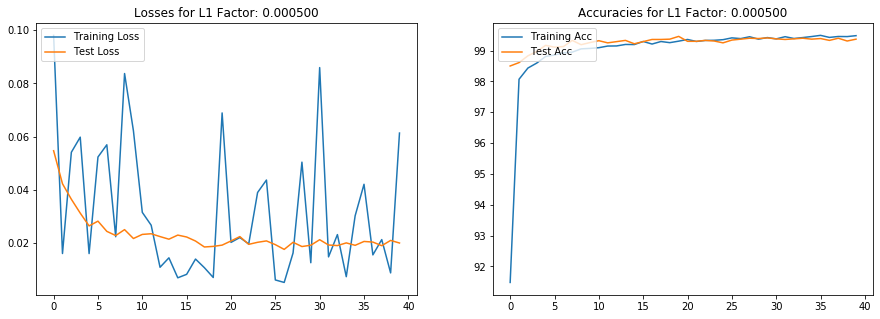

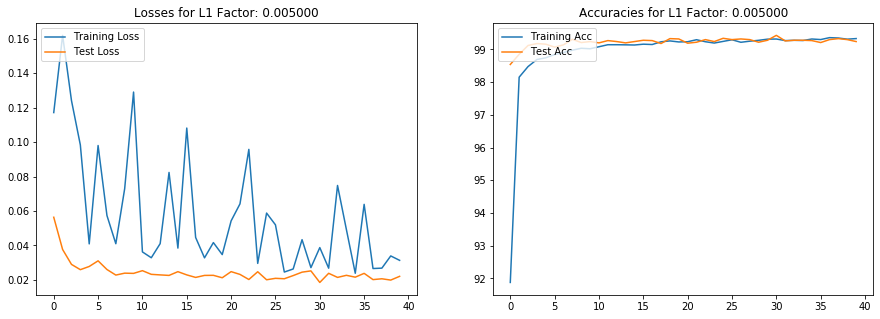

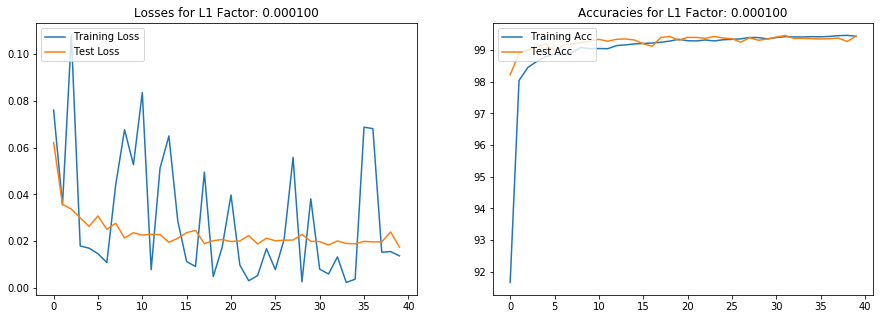

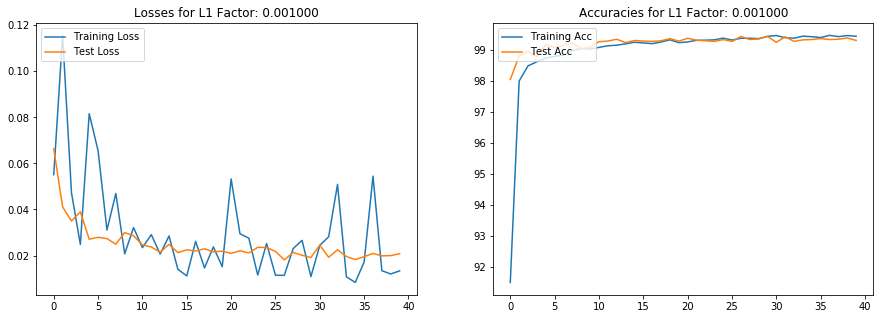

In [0]:
from torch.optim.lr_scheduler import StepLR
%matplotlib inline
import matplotlib.pyplot as plt

print('\n<<<<<<<< With L1 >>>>>>>>')
L1_Factor = [0.0005,0.005,0.0001,0.001]
L2_Factor = 0
for factor in L1_Factor:
    print('----------L1_Factor--------:',factor)
    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    train_acc_epoch = []
    train_losses_epoch = []

    model =  Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.9,weight_decay=L2_Factor)    
    scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

    EPOCHS = 40
    factor_in = factor
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch)
        train(model, device, train_loader, optimizer, epoch, factor_in)
        test(model, device, test_loader)

    print('\nMaxium test accuracy: {:.2f}, Achieved in epoch: {}, Max Train accuracy : {:.2f}, Achieved in epoch : {}\n'.format(
           max(test_acc),  np.argmax(test_acc) , max(train_acc_epoch), np.argmax(train_acc_epoch))   )
    figure = plt.figure(figsize=(15,5))
    labels = ['Training Loss', 'Test Loss']

    plt.subplot(1,2,1)
    plt.title("Losses for L1 Factor: %f" %factor)
    plt.plot(train_losses_epoch,label=labels[0])
    plt.plot(test_losses,label=labels[1])
    plt.legend(loc="upper left")

    labels = ['Training Acc', 'Test Acc']
    plt.subplot(1,2,2)
    plt.title("Accuracies for L1 Factor: %f" %factor)
    plt.plot(train_acc_epoch,label=labels[0])
    plt.plot(test_acc,label=labels[1])
    plt.legend(loc="upper left")

In [0]:
actual_img_s1 = []
wrong_pred_s0 = []
wrong_pred_s1 = []
actual_target_s0 = []
actual_target_s1 = []
for i in range(len(actual_img)):
    if actual_img[i].shape[0] == 1:
      actual_img_s1.append(actual_img[i])
      wrong_pred_s0.append(wrong_pred[i].reshape(1))
      actual_target_s0.append(actual_target[i].reshape(1))

for i in range(len(wrong_pred_s0)):
  wrong_pred_s1.append(wrong_pred_s0[i][0])  # To reduce to 1 dimension
  actual_target_s1.append(actual_target_s0[i][0]) 

print('Total Actual Images that were misclassified:',len(actual_img))
print('Total wrong predictions:', len(wrong_pred))
print('Retained Actual Images that were misclassified:', len(actual_img_s1))
print('Retained wrong predictions:', len(wrong_pred_s1))

Total Actual Images that were misclassified: 12640
Total wrong predictions: 12640
Retained Actual Images that were misclassified: 4097
Retained wrong predictions: 4097


    7      0        4        4          2 

    5      0        7        4          7 

    1      4        3        0          0 

    0      7        2        7          3 

    2      8        2        4          2


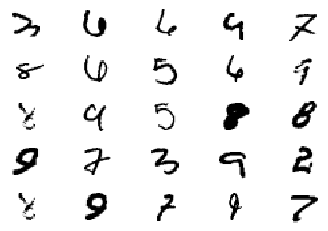

In [0]:
figure = plt.figure()
num_of_images = 25
i = 1
#figure = plt.figure(figsize=(15,15))
for index in range(1, num_of_images + 1):
          plt.subplot(5, 5, index)
          plt.axis('off')
          plt.imshow(actual_img_s1[index].reshape(28,28), cmap='gray_r') 

print('   ',wrong_pred_s1[1],'    ',wrong_pred_s1[2],'      ',wrong_pred_s1[3],'      ',wrong_pred_s1[4],'        ',wrong_pred_s1[5],'\n')
print('   ',wrong_pred_s1[6],'    ',wrong_pred_s1[7],'      ',wrong_pred_s1[8],'      ',wrong_pred_s1[9],'        ',wrong_pred_s1[10],'\n')
print('   ',wrong_pred_s1[11],'    ',wrong_pred_s1[12],'      ',wrong_pred_s1[13],'      ',wrong_pred_s1[14],'        ',wrong_pred_s1[15],'\n')
print('   ',wrong_pred_s1[16],'    ',wrong_pred_s1[17],'      ',wrong_pred_s1[18],'      ',wrong_pred_s1[19],'        ',wrong_pred_s1[20],'\n')
print('   ',wrong_pred_s1[21],'    ',wrong_pred_s1[22],'      ',wrong_pred_s1[23],'      ',wrong_pred_s1[24],'        ',wrong_pred_s1[25])

In [0]:
print ('    Actual Target Value in MNIST \n')
print('   ',actual_target_s1[1],'    ',actual_target_s1[2],'      ',actual_target_s1[3],'      ',actual_target_s1[4],'        ',actual_target_s1[5],'\n')
print('   ',actual_target_s1[6],'    ',actual_target_s1[7],'      ',actual_target_s1[8],'      ',actual_target_s1[9],'        ',actual_target_s1[10],'\n')
print('   ',actual_target_s1[11],'    ',actual_target_s1[12],'      ',actual_target_s1[13],'      ',actual_target_s1[14],'        ',actual_target_s1[15],'\n')
print('   ',actual_target_s1[16],'    ',actual_target_s1[17],'      ',actual_target_s1[18],'      ',actual_target_s1[19],'        ',actual_target_s1[20],'\n')
print('   ',actual_target_s1[21],'    ',actual_target_s1[22],'      ',actual_target_s1[23],'      ',actual_target_s1[24],'        ',actual_target_s1[25])

    Actual Target Value in MNIST 

    3      6        6        9          7 

    8      6        5        6          9 

    8      9        5        8          8 

    9      2        3        9          2 

    8      9        7        9          7
